TP 2 - Geodesics on meshes
=======================

This notebook doesn't require any toolkit, but the **scipy** Python module.

![](http://www.ceremade.dauphine.fr/~groscot/tp3-heat.png)

This lab focuses on 3D surfaces. Here is a list of what we'll explore:

1. Handling and displaying meshes
2. Computing differential operators
3. Finding geodesic distance by solving a Poisson equation
$\newcommand{\phi}{\varphi}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\norm}[1]{\|#1\|}$

Make sure these imports succeed before going any further

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse

# Dealing with meshes

The topology of a triangulation is defined via a set of indices $\Vv = \{1,\ldots,n\}$ that indexes the $n$ vertices, a set of edges $\Ee \subset \Vv \times \Vv$ and a set of $m$ faces $\Ff \subset \Vv  \times \Vv \times \Vv$.

We load a mesh:

1. The positions $x_i \in \RR^3$, for $i \in V$, of the $n$ vertices are stored in a matrix $X_0 = (x_{0,i})_{i=1}^n \in \RR^{3 \times n}$.
2. The set of faces $\Ff$ is stored in a matrix $F \in \{1,\ldots,n\}^{3 \times m}$.

In [ ]:
def read_mesh(name):
    with open(name, mode="r") as file:
        
        #check type of file
        file_type = file.readline().strip()
        if file_type != "OFF":
            raise Exception("Wrong type of file, only reads OFF files")
        #number of vertices/faces/edges:
        n_verts, n_faces, n_edges = tuple([int(s) for s in file.readline().strip().split(' ')])
        #vertices
        X0 = []
        for _ in range(n_verts):
            X0.append(file.readline().strip().split(' '))
        #faces
        F = []
        for i in range(n_faces):
            F.append(file.readline().strip().split(' ')[1:])
    return np.asarray(X0).astype(float), np.asarray(F).astype(int)

Displaying a mesh in Python is pretty slow. Below is the function you'll be using thoughout the lab, which allows to change the color of the patches to represent a **scalar-valued function** on the mesh, by defining a function on the vertices. For exhaustivity purposes, it also allows to define a function on the triangles, but from now on all references to a function on the surface will mean that it's defined on the vertices.

> **Note**: vector-valued functions are not implemented. You shouldn't need them for the lab.

In [ ]:
def plot_mesh(X, F, subplot = [1,1,1], title="", el=0, az=0, lwdt=.1, dist=6, c="grey",
              face_func=None, vertex_func=None):
    X = X.T
    ax = plt.subplot(subplot[0],subplot[1],subplot[2], projection='3d')
    collec = ax.plot_trisurf(X[0,:], X[1,:], X[2,:], triangles=F, lw=lwdt, color=c, alpha=1)
    if face_func is not None:
        collec.set_array(face_func)
    if vertex_func is not None:
        vertex_value = lambda v: np.mean(np.stack([v[F[:,0]], v[F[:,1]], v[F[:,2]]]), axis=0)
        collec.set_array(vertex_value(vertex_func))
    ax.axis("off")
    #ax.set_aspect('equal')
    ax.view_init(elev=el, azim=az)
    ax.dist = dist
    
    # Create cubic bounding box to simulate equal aspect ratio
    # this is a hack to prevent a change in aspect ratio during rotation
    x = X[0,:]
    y = X[1,:]
    z = X[2,:]
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    
    plt.title(title)
    return ax #need the ax object for the last section of the lab

Load the example mesh (provided in the archive) and display it

**IMPORTANT**

Jupyter plots can be interactive or fixed. You can change the behaviour for all subsequent plots using IPython magics (single line starting by a `%`):

- `%matplotlib inline` asks for fixed images
- `%matplotlib notebook` allows for interactivity (rotating the 3D plot)

You should take care of the following points:

1. `%matplotlib notebook` can be pretty erratic sometimes... if the output of the cell is blank, ty to run it again for a few times (or duplicate the magic line, sometimes it works...)
2. when you have an `interactive` plot, **always** end it by clicking on the 'turn off' button (top-right corner) before reverting to `inline` plots

As for the mesh, you have the same model in three different resolutions (5k faces, 15k and 50k). We strongly recommend to work on the low-res model, because it will make all your computations faster (and you'll probably notice that the 3D visualization will be pretty slow). You can test a few methods on the 15k, and eventually switch to the 50k version once you've finished the lab, to see much nicer results (you might want to change a few parameters then). Beware, an interactive plot with this version might be _really_ slow to register your mouse commands when you try to rotate the view.

```python
# Comment out all-but-one lines
name = 'elephant-5kf.off'
name = 'elephant-15kf.off'
name = 'elephant-50kf.off'
```

In [ ]:
name = 'elephant-5kf.off'
#name = 'elephant-15kf.off'
#name = 'elephant-50kf.off'# turn this on ONLY AFTER completing the whole Lab
X,F = read_mesh(name)

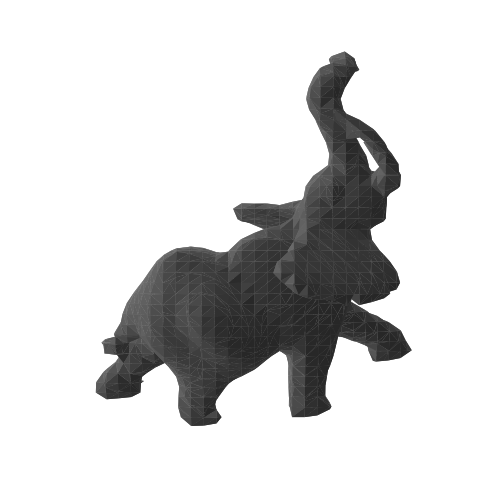

In [ ]:
%matplotlib inline
plt.figure(figsize=(7,7))
plot_mesh(X,F)
plt.tight_layout()
plt.show()

#### Exercise

In a grid, display a few functions on that mesh (you can think of the coodinate functions, for instance)

[-0.4710205 -0.4804734 -0.4710205 ...  0.4785386  0.4885476  0.4752039]


<Axes3DSubplot:>

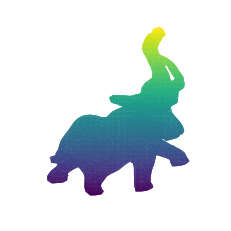

In [ ]:
v_func = X.T[2,:]

print(v_func)

plot_mesh(X,F,vertex_func=v_func)

Number $n$ of vertices and number $m$ of faces:

In [ ]:
n = X.shape[0]
m = F.shape[0]
print("Model contains: {} vertices, {} faces".format(n,m)) 

Model contains: 2380 vertices, 4760 faces


# Gradient, Divergence and Laplacian on Surfaces

In this lab, we use piecewise linear finite elements to compute our differential operators, which in turn allows us to compute the Laplacian in order to solve a heat equation.

> You can use the following document for a technical reference about the discrete Laplacian: 
> 
> https://graphics.stanford.edu/courses/cs468-13-spring/assets/lecture12-lu.pdf

## Laplacian as div(grad)

The gradient operator $\nabla$ can be understood as a collection of 3 sparse matrices $(\nabla_s)_{s=1,2,3}$ of size $(m,n)$ that computes each coordinate of $\nabla u=(\nabla_s u)_{s=1,2,3}$ through the formula, for each face $f$, 

$$(\nabla u)_f = \frac{1}{2A_f} \sum_{i \in f} u_i (N_f \wedge e_i)$$

- $A_f$ is the area of face $f$
- $N_f$ is the normal to the face
- $e_i$ is the edge opposite to vertex $i$
- $\wedge$ is the cross product in $\RR^3$

Callback to get the coordinates of all the vertex of index $i=1,2,3$ in all faces.

In [ ]:
XF = lambda i: X[F[:,i-1], :]

#### Exercise

You have to implement the Laplacian computation. You'll be guided step by step and just need to fill in the blanks. Don't change the suggested variables names because you'll need them for the rest of the lab

1. Compute un-normalized normal through the formula $e_1 \wedge e_2$ where $e_i$ are the edges.

In [ ]:
Na = np.cross(XF(2)-XF(1),XF(3)-XF(2))
#print(Na)

2. Compute the area of each face as half the norm of the cross product.

In [ ]:
amplitude = lambda X: np.sqrt(np.sum(X**2, axis=1)) # shorthand to compute vector norm
A = 0.5*amplitude(Na)

3. Compute the set of unit-norm normals to each face.

In [ ]:
normalize = lambda X : X/amplitude(X)[:,np.newaxis]

In [ ]:
N = normalize(Na)

4. Populate the sparse entries of the matrices for the operator implementing $\sum_{i \in f} u_i (N_f \wedge e_i)$

In [ ]:
I = []
J = []
V = []
for i in range(1,4):
    # opposite edge e_i indexes
    s = i%3 + 1;
    t = (i+1)%3 + 1;
    # vector N_f^e_i
    wi = np.cross(XF(t)-XF(s), N)
    # update the index listing
    # /!\ RANGE renvoie un iterator en Python3!!
    # list(range(m))
    I = I + list(range(m))
    J = J + F[:,i-1].tolist()
    V = V + [wi]
    

5. Create a sparse diagonal matrix with entries $1/(2A_f)$

In [ ]:
dA = sparse.diags(1./(2.*A))

6. Gradient operator

In [ ]:
V = np.concatenate(V)
GradMat = [dA * sparse.coo_matrix((V[:,i], (I,J))) for i in range(3)]

In [ ]:
Grad = lambda f: [GradMat[0]*f,GradMat[1]*f,GradMat[2]*f]

7. Compute divergence matrices as transposed of grad for the face area inner product.

In [ ]:
dAf = sparse.diags(2.*A)
DivMats = [GradMat[i].T*dAf for i in range(3)]

8. Div operator

In [ ]:
Div = lambda V: DivMats[0]*V[0] + DivMats[1]*V[1] + DivMats[2]*V[2]

9. Laplacian operator as the composition of grad and div.

In [ ]:
Delta = DivMats[0]*GradMat[0] + DivMats[1]*GradMat[1] + DivMats[2]*GradMat[2]

## Cotangent Laplacian

We can also directly compute the Laplacian using a cotangent weighting scheme (as described in https://graphics.stanford.edu/courses/cs468-13-spring/assets/lecture12-lu.pdf)

Cotan of an angle between two vectors.

In [ ]:
# numpy doesn't implement a cotangent function...
def cota(a,b):
    x = np.arccos(np.sum(normalize(a) * normalize(b), axis=1))
    return np.cos(x)/(np.sin(x) + 1e-8)

#### Exercise

Implement the cotangent version of the Laplacian, stored in a sparse matrix (use the same structure as the previous part)

In [ ]:
# indexes to build the sparse matrices
I = []
J = []
V = []
# area of face around vertices (diagonal sparse matrix)
Ia = []
Va = []

In [ ]:
for i in range(1,4):
    # opposite edge e_i indexes
    s = i%3 + 1;
    t = (i+1)%3 + 1;
    # adjacent edge
    ctheta = cota(XF(s)-XF(i), XF(t)-XF(i))
    # update the index listing
    lt = F[:,t-1].tolist()
    ls = F[:,s-1].tolist()
    I = I + ls + lt
    J = J + lt + ls
    V = V + [ctheta, ctheta]
    # update the diagonal with area of face around vertices
    Ia = Ia + F[:,i-1].tolist()
    Va = Va + [A]
    
V = np.concatenate(V).tolist()
Va = np.concatenate(Va).tolist()
# Area diagonal matrix
Ac = sparse.coo_matrix((Va, (Ia,Ia)))
# Cotan weights
Wc = sparse.coo_matrix((V, (I,J)))

DeltaCot = sparse.diags(np.array(np.sum(Wc, axis=0)).squeeze()) - Wc

Check that the Laplacian with cotan weights is actually equal to the composition of divergence and gradient.

In [ ]:
print("Should be small:", np.linalg.norm((Delta - DeltaCot).toarray())/np.linalg.norm(Delta.toarray()))

Should be small: 8.100965780868504e-05


Display a function on the mesh along with its Laplacian

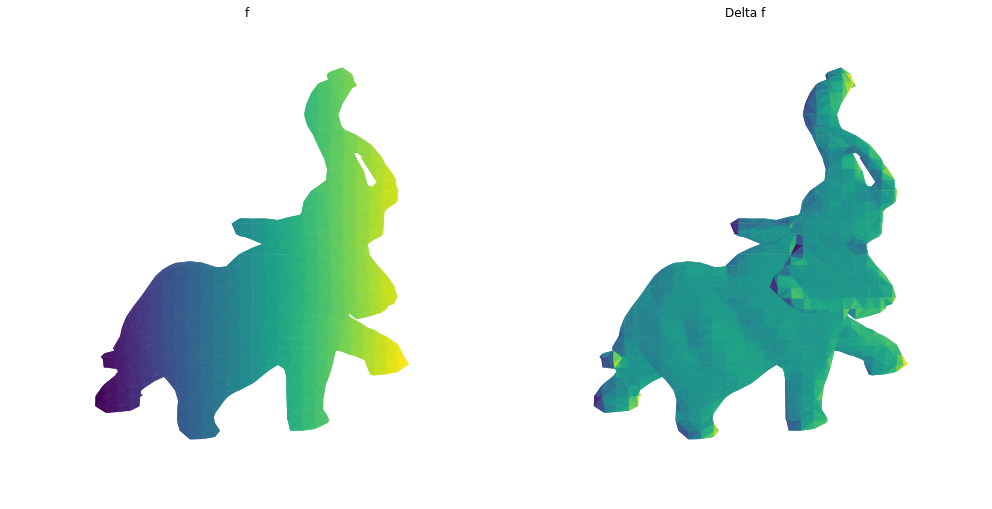

In [ ]:
f = X[:,1]

plt.figure(figsize=(14,7))
plot_mesh(X,F,subplot=[1,2,1],title="f", vertex_func=f)
plot_mesh(X,F,subplot=[1,2,2],title="Delta f",vertex_func=Delta*f)

plt.tight_layout()
plt.show()

# Heat Diffusion and Time Stepping

We want to compute geodesic distances by solving the heat diffusion equation:

$$\frac{\partial u}{\partial t} = -\Delta u$$

The method developped in [CraneWeischedelWardetzky13](#Bibliography) relies on the fact that the level set of the geodesic distance function to a starting point $i$ agrees with the level set of the solution of the heat diffusion when the time of diffusion tends to zero. This fundamental result is proved in [Varadhan67](#Bibliography).

In fact, the same result holds true when replacing the heat diffusion solution by a single Euler implicit step in time, with time step $t$. This means one should consider the solution u to the equation

$$(\text{Id}+t \Delta) u = \delta_i$$

where $\delta_i$ is the Dirac vector at vertex index $i$.

Select index $i$, at the tip of the trunk

In [ ]:
i = 2367 #for the 5k model
#i = 120 #for the 15k model
#i = 21000 #for the 50k model

Set time $t$

In [ ]:
t = 10

Solve the linear system.

In [ ]:
delta = np.zeros((n,1))
delta[i] = 1

In [ ]:
u = np.squeeze(np.linalg.solve((Ac+t*Delta).toarray(),delta))

Display this solution, using a different color grading

In [ ]:
def color_grading(u,p):
    # remap to 0-1, then periodize
    y = (u - u.min())/(u.max() - u.min())
    return np.cos(p * 2.*np.pi*y);

<ipython-input-40-8f31c84456f1>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(subplot[0],subplot[1],subplot[2], projection='3d')


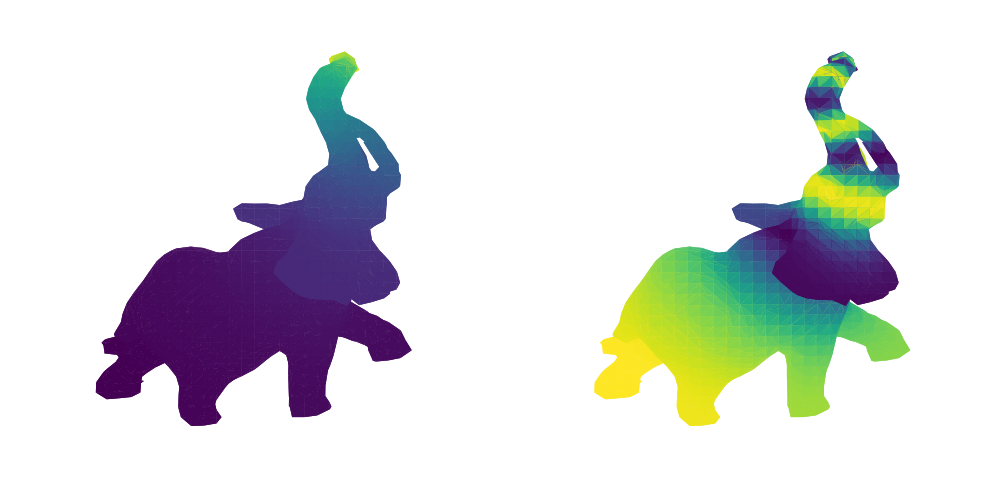

In [ ]:
plt.figure(figsize=(14,7))
plot_mesh(X,F,subplot=[1,2,1],vertex_func=u)
plt.subplot(1,2,2)
plot_mesh(X,F,subplot=[1,2,2],vertex_func=color_grading(u,5))

plt.tight_layout()
plt.show()

#### Exercise

You can solve the general heat diffusion equation

$$\frac{\partial u}{\partial t} = -\Delta u$$

by iterating several passes of implicit time stepping. Pay attention to the value of $t$. Display a few steps in a $2 \times 2$ grid. Note that the Heat method does not require an exact solution to the heat equation.

<ipython-input-40-8f31c84456f1>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(subplot[0],subplot[1],subplot[2], projection='3d')


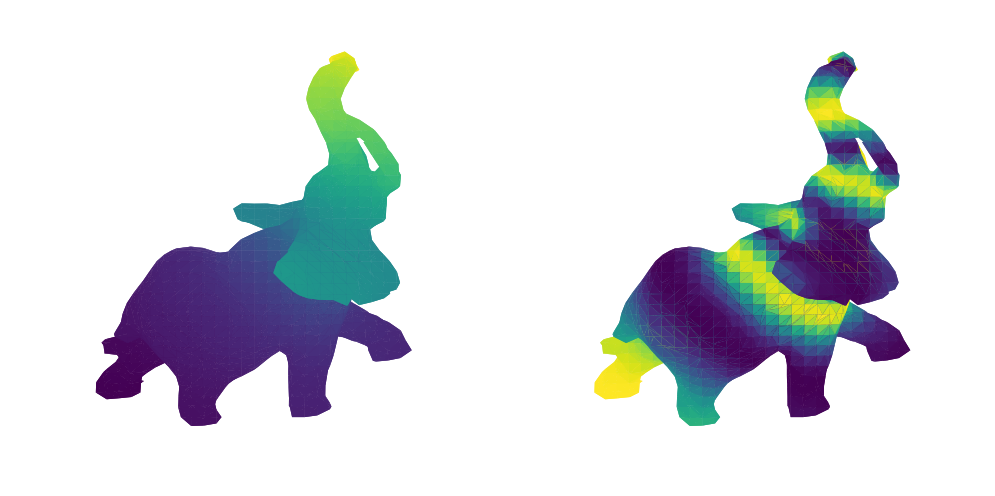

In [ ]:

delta = np.zeros((n,1))
delta[i] = 1

N_time = 10;
Tf = 0.5;
dt = Tf/N_time

u=delta

for k in range(N_time):
    u = np.squeeze(np.linalg.solve((Ac+dt*Delta).toarray(),u))

plt.figure(p,figsize=(14,7))
plot_mesh(X,F,subplot=[1,2,1],vertex_func=u)
plt.subplot(1,2,2)
plot_mesh(X,F,subplot=[1,2,2],vertex_func=color_grading(u,5))

plt.tight_layout()
plt.show()

# Geodesic in Heat method

The main point of the method [CraneWeischedelWardetzky13](#Bibliography) is to retrieve an approximation of the distance function $\phi$ from the level set of implicit heat diffusion step u.

This is achieved by using the fact that $\norm{\nabla \phi}=1$, i.e. one should have at first order $\nabla \phi \approx -\frac{\nabla u}{\norm{\nabla u}}$, and:

$$\text{div}(\nabla \phi) = \text{div}(-\frac{\nabla u}{\norm{\nabla u}})$$

$$\Delta \phi = \text{div}(-\frac{\nabla u}{\norm{\nabla u}})$$
            
This is another Poisson equation, that we can solve just as seen previously.

#### Exercise

1. Solve this equation. First, compute $u$ as a 1-step solution of heat (with implicit time stepping). Then you can solve for $\phi$.
2. Display the resulting $\phi$ obtained for several time step $t$ values. 

<Axes3DSubplot:>

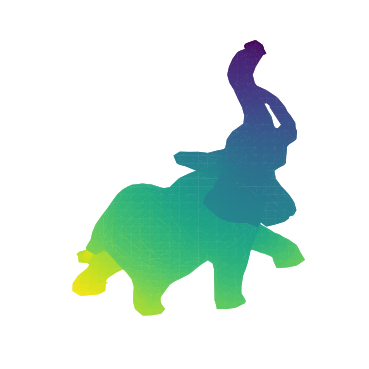

In [ ]:
t=1
delta = np.zeros((n,1))
delta[i] = 1

u = np.squeeze(np.linalg.solve((Ac+t*Delta).toarray(),delta))

grad_u = Grad(u)

grad_u_normalized = [-(grad_u[p])/np.sqrt(grad_u[0]**2+grad_u[1]**2+grad_u[2]**2) for p in range(3)]

phi = np.squeeze(np.linalg.solve((Delta).toarray(),Div(grad_u_normalized)))

plt.figure(1,figsize=(14,7))
plot_mesh(X,F,subplot=[1,2,1],vertex_func=phi)

# Farthest point sampling

You can now use this distance map to implement farthest point sampling

#### Exercise
Implement farthest point sampling. Use the following image as a reference.

![broken link, maybe your internet connection is down](http://www.ceremade.dauphine.fr/~groscot/fps.png)

Don't forget to show spheres located at the selected positions. To do so,
you need to call `ax.scatter()` where `ax` is a 3D axis system, for instance the one returned by `plot_mesh()`: `ax.scatter(x_list, y_list, z_list,s=100)`)

<Axes3DSubplot:>

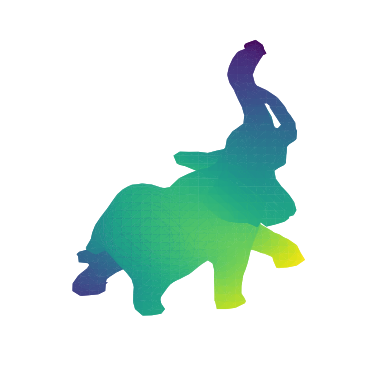

In [ ]:
new_indice = phi.argmax()

list_of_indices = [i,new_indice
                  ]
t=100
delta = np.zeros((n,1))
delta[list_of_indices] = 1

u = np.squeeze(np.linalg.solve((Ac+t*Delta).toarray(),delta))

grad_u = Grad(u)

grad_u_normalized = [-(grad_u[p])/np.sqrt(grad_u[0]**2+grad_u[1]**2+grad_u[2]**2) for p in range(3)]

phi = np.squeeze(np.linalg.solve((Delta).toarray(),Div(grad_u_normalized)))

plt.figure(1,figsize=(14,7))
plot_mesh(X,F,subplot=[1,2,1],vertex_func=phi)


<Axes3DSubplot:>

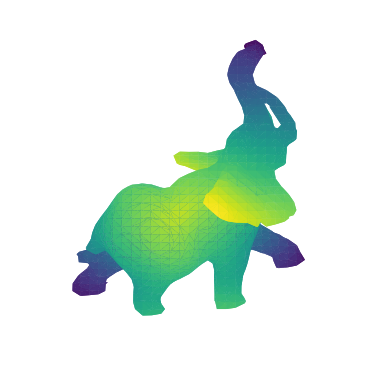

In [ ]:
new_indice = phi.argmax()

list_of_indices = list_of_indices + [new_indice]
t=100
delta = np.zeros((n,1))
delta[list_of_indices] = 1

u = np.squeeze(np.linalg.solve((Ac+t*Delta).toarray(),delta))

grad_u = Grad(u)

grad_u_normalized = [-(grad_u[p])/np.sqrt(grad_u[0]**2+grad_u[1]**2+grad_u[2]**2) for p in range(3)]

phi = np.squeeze(np.linalg.solve((Delta).toarray(),Div(grad_u_normalized)))

plt.figure(1,figsize=(14,7))
plot_mesh(X,F,subplot=[1,2,1],vertex_func=phi)

<Axes3DSubplot:>

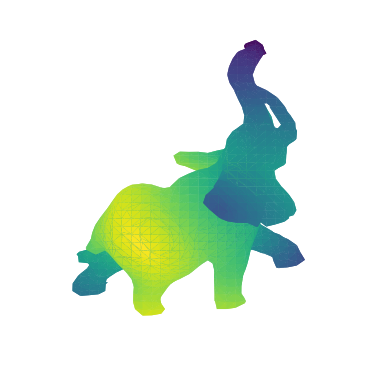

In [ ]:
new_indice = phi.argmax()

list_of_indices = list_of_indices + [new_indice]
t=100
delta = np.zeros((n,1))
delta[list_of_indices] = 1

u = np.squeeze(np.linalg.solve((Ac+t*Delta).toarray(),delta))

grad_u = Grad(u)

grad_u_normalized = [-(grad_u[p])/np.sqrt(grad_u[0]**2+grad_u[1]**2+grad_u[2]**2) for p in range(3)]

phi = np.squeeze(np.linalg.solve((Delta).toarray(),Div(grad_u_normalized)))

plt.figure(1,figsize=(14,7))
plot_mesh(X,F,subplot=[1,2,1],vertex_func=phi)

In [ ]:
new_indice = phi.argmax()

list_of_indices = list_of_indices + [new_indice]
t=100
delta = np.zeros((n,1))
delta[list_of_indices] = 1

u = np.squeeze(np.linalg.solve((Ac+t*Delta).toarray(),delta))

grad_u = Grad(u)

grad_u_normalized = [-(grad_u[p])/np.sqrt(grad_u[0]**2+grad_u[1]**2+grad_u[2]**2) for p in range(3)]

phi = np.squeeze(np.linalg.solve((Delta).toarray(),Div(grad_u_normalized)))

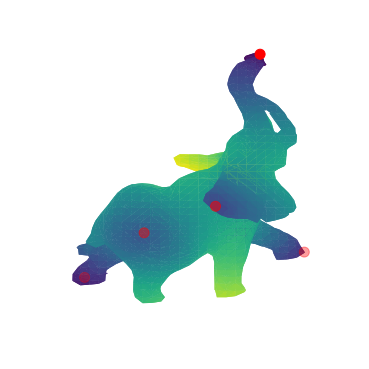

In [ ]:
x_list = X.T[1,list_of_indices]
y_list = X.T[2,list_of_indices]
z_list = X.T[2,list_of_indices]

plt.figure(1,figsize=(14,7))
ax=plot_mesh(X,F,subplot=[1,2,1],vertex_func=phi)
ax.scatter(y_list,x_list,z_list,s=100,c='r')

# You're finished!

__Student name__

Replace this cell with your name
(double click to edit the cell, then render by executing like a code cell, `Shift+Enter`)

Once you've finished the lab, export it into a fixed HTML file and email it to me. Don't worry, it won't be graded - the only effect it can have on your final class grade is positive. You can follow these steps:

1. Export to HTML using the menu `File` > `Download as` > `HTML (.html)`
2. Rename the file using the following scheme: `TP2_nom_prenom.html`, for instance `TP2_dupont_jean.html`
3. Send it to the following address: groscot@ceremade.dauphine.fr

###### .THE END.

# Bibliography

- **[CraneWeischedelWardetzky13]** K. Crane, C. Weischedel, M. Wardetzky, _Geodesics in heat: A new approach to computing distance based on heat flow_, ACM Transactions on Graphics , vol. 32, no. 5, pp. 152:1-152:11, 2013.
- **[Varadhan67]** S.R.S. Varadhan, _On the behavior of the fundamental solution of the heat equation with variable coefficients_, Communications on Pure and Applied Mathematics 20, 2, 431-455, 1967